# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных



Данные геологоразведки трёх регионов:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

In [2]:
df0=pd.read_csv('/datasets/geo_data_0.csv')
df1=pd.read_csv('/datasets/geo_data_1.csv')
df2=pd.read_csv('/datasets/geo_data_2.csv')
display(df0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Посмотрим данные трех файлов: есть ли пропуски в данных или дубликаты

In [3]:
df0.info()
print()
print('Количество дубликатов:', df0.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0


In [4]:
df1.info()
print()
print('Количество дубликатов:', df1.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0


In [5]:
df2.info()
print()
print('Количество дубликатов:', df2.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0


Пропусков и дубликатов нет. 4 колонки с дробными числами и 1 колонка **id** с категориальным признаком.

**id** - это уникальный идентификатор скважины. Если проводить кодирование этого столбца, то таблица станет очень большой и время на обучение модели уйдет много. Но на обучение модели этот признак не влияет, поэтому удалим столбец из всех трех файлов. 

In [6]:
df0=df0.drop(['id'], axis=1)
display(df0.head(3))

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647


In [7]:
df1=df1.drop(['id'], axis=1)
display(df1.head(3))

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305


In [8]:
df2=df2.drop(['id'], axis=1)
display(df2.head(3))

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910


Посмотрим максимальные и минимальные значения признаков, чтобы определить нужно ли проводить масштабирование

In [9]:
print('Регион0:', df0['f0'].min(), df0['f0'].max(), df0['f1'].min(), df0['f1'].max(), df0['f2'].min(), df0['f2'].max())

Регион0: -1.4086053060269959 2.3623308108542243 -0.8482184970082173 1.343769333804496 -12.088328118063359 16.003790007695365


In [10]:
print('Регион1:', df1['f0'].min(), df1['f0'].max(), df1['f1'].min(), df1['f1'].max(), df1['f2'].min(), df1['f2'].max())

Регион1: -31.60957601916769 29.42175461390372 -26.358598008345872 18.734062633730762 -0.01814408671342021 5.019720555223062


In [11]:
print('Регион2:', df2['f0'].min(), df2['f0'].max(), df2['f1'].min(), df2['f1'].max(), df2['f2'].min(), df2['f2'].max())

Регион2: -8.760003624213763 7.23826247979405 -7.084019760867246 7.844801270084258 -11.97033454147699 16.73940205869952


Все признаки в регионе одного масштаба.

**Вывод**. В данных нет пропусков и дубликатов. Удалена колонка id, тк она не оказывает влияние на обучение модели. 
Мастабирование признаков проводить не нужно. 

## Обучение и проверка модели

**Регион0**. 

Обучим модель для региона0. 

Разобъем данные на признаки и целевой признак. Целевой признак это колонка **product** — объём запасов в скважине (тыс. баррелей)

In [12]:
target0 = df0['product'] # столбец с целевым признаком
features0 = df0.drop(['product'], axis=1) # таблица с признаками. 

Для обучения и проверки модели разобъем данные на 2 выборки: обучающая и валидационная в пропорции 75:25.  И проверим правильно ли получилось разделить. 

In [13]:
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
        features0,target0, test_size=0.25, random_state=12345)
print('Размер обучающей выборки', features_train0.shape)
print('Размер валидационной выборки', features_valid0.shape)

Размер обучающей выборки (75000, 3)
Размер валидационной выборки (25000, 3)


Разделение получилось верное. 

Тк целевой признак - количественный (колонка **poduct**), то у нас задача регрессии. Возьмем модель линейной регрессии.

In [14]:
model0 = LinearRegression()
model0.fit(features_train0, target_train0)
predictions0=model0.predict(features_valid0)
mse0=mean_squared_error(target_valid0,predictions0)
rmse0=math.sqrt(mse0)
print("RMSE региона0:", rmse0 )
print('Средний запас предсказанного сырья:', predictions0.mean())

RMSE региона0: 37.5794217150813
Средний запас предсказанного сырья: 92.59256778438038


Проверим модель на адекватность. Сравним модель с константной моделью, которая любому объекту прогнозирует среднее значение из выборки

In [15]:
predicted_valid0=pd.Series(target_train0.mean(), index=target_valid0.index)
mse_const0=mean_squared_error(target_valid0,predicted_valid0 )
rmse_const0=math.sqrt(mse_const0)
print(rmse_const0)

44.289591053907365


RMSE у модели получился большим, но все же ниже чем у константной модели

**Регион1**. 

Обучим модель для региона1. 

Разобъем данные на признаки и целевой признак. Целевой признак это колонка **product** — объём запасов в скважине (тыс. баррелей). Также разобъем данные на 2 выборки: обучающая и валидационная в пропорции 75:25. И проверим правильно ли получилось разделить.

In [16]:
target1 = df1['product'] # столбец с целевым признаком
features1 = df1.drop(['product'], axis=1) # таблица с признаками. 
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
        features1,target1, test_size=0.25, random_state=12345)
print('Размер обучающей выборки', features_train1.shape)
print('Размер валидационной выборки', features_valid1.shape)

Размер обучающей выборки (75000, 3)
Размер валидационной выборки (25000, 3)


Разделение получилось верное. 

Также как для региона0 обучим модель линейной регресии для региона1

In [17]:
model1 = LinearRegression()
model1.fit(features_train1, target_train1)
predictions1=model1.predict(features_valid1)
mse1=mean_squared_error(target_valid1,predictions1)
rmse1=math.sqrt(mse1)
print("RMSE региона 1:", rmse1 )
print('Средний запас предсказний:', predictions1.mean())

RMSE региона 1: 0.893099286775616
Средний запас предсказний: 68.728546895446


Проверим модель на адекватность. Сравним модель с константной моделью, которая любому объекту прогнозирует среднее значение из выборки

In [18]:
predicted_valid1=pd.Series(target_train1.mean(), index=target_valid1.index)
mse_const1=mean_squared_error(target_valid1,predicted_valid1 )
rmse_const1=math.sqrt(mse_const1)
print(rmse_const1)

46.02144533725462


RMSE у модели получился очень маленький=0.9 (и гораздно ниже константной модели), а средний запас получился небольшим =68,7 тыс баррелей- это значительно меньше чем у региона0.

**Регион2**. 

Обучим модель для региона2. 

Разобъем данные на признаки и целевой признак. Целевой признак это колонка **product** — объём запасов в скважине (тыс. баррелей). Также разобъем данные на 2 выборки: обучающая и валидационная в пропорции 75:25. И проверим правильно ли получилось разделить.

In [19]:
target2 = df2['product'] # столбец с целевым признаком
features2 = df2.drop(['product'], axis=1) # таблица с признаками. 
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
        features2,target2, test_size=0.25, random_state=12345)
print('Размер обучающей выборки', features_train2.shape)
print('Размер валидационной выборки', features_valid2.shape)


Размер обучающей выборки (75000, 3)
Размер валидационной выборки (25000, 3)


Разделение получилось верное. 

Также как и для предыдущих регионов обучим модель линейной регресии для региона2

In [20]:
model2 = LinearRegression()
model2.fit(features_train2, target_train2)
predictions2=model2.predict(features_valid2)
mse2=mean_squared_error(target_valid2,predictions2)
rmse2=math.sqrt(mse2)
print("RMSE региона2:", rmse2 )
print('Средний запас предсказний:', predictions2.mean())

RMSE региона2: 40.02970873393434
Средний запас предсказний: 94.96504596800489


Проверим модель на адекватность. Сравним модель с константной моделью, которая любому объекту прогнозирует среднее значение из выборки

In [21]:
predicted_valid2=pd.Series(target_train2.mean(), index=target_valid2.index)
mse_const2=mean_squared_error(target_valid2,predicted_valid2 )
rmse_const2=math.sqrt(mse_const2)
print(rmse_const2)

44.90234968510566


У региона2 высокий средний запас и высокий RMSE (но ниже чем у константной модели). 

**Выводы**. Самый высокий средний запас модель предсказала для региона2 ~ 95 тыс баррелей. Но и RMSE получился самым высоким = 40.
Самый низкий RMSE получился у региона1= 0.9 и средний запас сырья модель предсказала самый низкий.  У региона0 RMSE и средний запас чуть ниже чем у региона2.

Проверка на адекватность показала, что модели работают лучше чем константная модель


## Подготовка к расчёту прибыли

Запишем ключевые значения для расчёта прибыли

In [22]:
cost_price = 10000000000   #Бюджет на разработку скважин в регионе, т.е. расходы.
wells= 200                 #Количество скважин, которое берется в разработку
revenue_per_unit = 450000  #Цена единицы продукции (тыс. баррелей)

Рассчитаем какой должен быть объем добываемого сырья у каждой из 200 скважин, чтобы как минимум покрыть расходы.

In [23]:
volume_per_well = cost_price/revenue_per_unit/wells
print('Достаточный объём сырья для безубыточной разработки новой скважины, тыс. баррелей: ', volume_per_well )

Достаточный объём сырья для безубыточной разработки новой скважины, тыс. баррелей:  111.11111111111111


Посмотрим на средний запас сырья в каждом регионе.

In [24]:
print('Средний запас сырья региона0, тыс. баррелей:', target0.mean())

Средний запас сырья региона0, тыс. баррелей: 92.50000000000001


In [25]:
print('Средний запас сырья региона1, тыс. баррелей:', target1.mean())

Средний запас сырья региона1, тыс. баррелей: 68.82500000000002


In [26]:
print('Средний запас сырья региона2, тыс. баррелей:', target2.mean())

Средний запас сырья региона2, тыс. баррелей: 95.00000000000004


**Вывод**. Если в регионе будут отбирать 200 скважин для разработки и стоимость единицы продукции будет составлять 450К рублей, то для того чтобы как минимум покрыть расходы на разработку=10 млрд. руб, с каждой скажины необходимо добывать как минимум 111,11 тыс баррелей. 

Средний запас одной скважины в каждом из 3-х регионов ниже 111.11. Больше всего средний запас в регионе2, он составляет 95 тыс. баррелей.

## Расчёт прибыли и рисков 

Для удобства расчетов переведем данные предсказаний моделей в series c cохранением индексов по данным в target.

In [27]:
predictions0 = pd.Series(predictions0, index=target_valid0.index)
predictions1 = pd.Series(predictions1, index=target_valid1.index)
predictions2 = pd.Series(predictions2, index=target_valid2.index)

Напишем функцию для расчёта прибыли по скважинам с максимальными значениями предсказаний

In [28]:
def revenue(target, predictions,count):
    predict_sorted=predictions.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    return revenue_per_unit*selected.sum()-cost_price #Прибыль для полученного объёма сырья: оборот - расходы

Используем технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [29]:
def boots_method(target_valid, predictions):
    target_valid=target_valid
    predictions=predictions
    state=np.random.RandomState(12345)
    values=[]
    for i in range(1000):
        target_subsample = target_valid.sample(n=500, replace=True, random_state=state)
        predict_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, predict_subsample,200))
    values=pd.DataFrame(values, columns=['revenue'])
    lower=values['revenue'].quantile(0.05)
    upper=values['revenue'].quantile(0.95)
    mean=values['revenue'].mean()
    print('Доверительный интервал, min: {:,.2f}'.format(lower))
    print('Доверительный интервал, max: {:,.2f}'.format(upper))
    print('Средняя прибыль: {:,.2f}'.format(mean))
    negrevenue_wills= values[values['revenue']<0]       # выборка по скважинам с убытками 
    risk_wills = negrevenue_wills['revenue'].count()/values['revenue'].count()*100  #расчет доли убыточных скважин из общего числа скважин
    print('Доля скважин, которые будут приносить убыток, %:',  risk_wills)
    values['revenue']= values['revenue']/1000000    # уменьшим кол-во нулей, чтобы цифры на графике по оси Y отображались в удобном виде 
    ax=values.plot(kind='hist', bins=12, grid=True)  
    ax.set_xlabel('Прибыль, млн.руб.', fontsize=13)
    ax.vlines(0, 0, 230, color= 'k', linestyle ='--',)
    plt.show()
   

Доверительный интервал, min: -31,803,114.35
Доверительный интервал, max: 881,341,454.36
Средняя прибыль: 425,938,526.91
Доля скважин, которые будут приносить убыток, %: 6.0


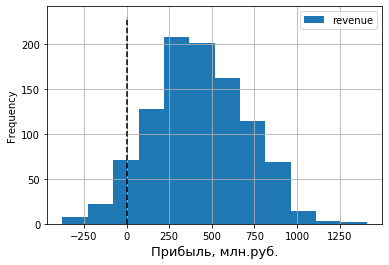

In [30]:
boots_method(target_valid0, predictions0)

Доверительный интервал, min: 150,785,740.64
Доверительный интервал, max: 861,521,464.10
Средняя прибыль: 515,222,773.44
Доля скважин, которые будут приносить убыток, %: 1.0


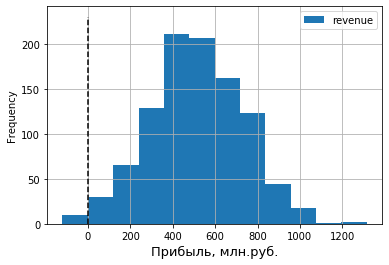

In [31]:
boots_method(target_valid1, predictions1)

Доверительный интервал, min: -43,448,491.32
Доверительный интервал, max: 897,954,688.90
Средняя прибыль: 435,008,362.78
Доля скважин, которые будут приносить убыток, %: 6.4


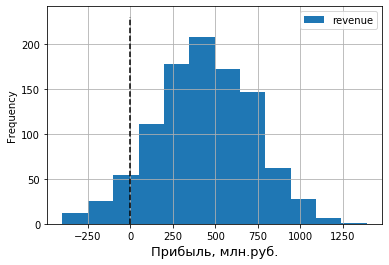

In [32]:
boots_method(target_valid2, predictions2)

Посмотрим на данные 3-х регионов в таблице

In [33]:
data = {'Регион': [0, 1, 2], 'Средняя прибыль, млн. руб.': [425.9, 515.2, 435.0],
        'Доверительный интервал, млн. руб.': ['-31.8 / 881.3', '150.7 / 861.5 ', '-43.4 / 897.9'], 
         'Доля убыточных скважин, %':[ 6.0, 1.0, 6.4 ]}
data_pivot = pd.DataFrame.from_dict(data)
display(data_pivot)

,Регион,"Средняя прибыль, млн. руб.","Доверительный интервал, млн. руб.","Доля убыточных скважин, %"
0,0,425.9,-31.8 / 881.3,6.0
1,1,515.2,150.7 / 861.5,1.0
2,2,435.0,-43.4 / 897.9,6.4


**Вывод**. Для разработки месторождения подходит регион1. В этом регионе получилась наибольшая средняя выручка с 1 скважины (515 млн. рублей) и доля скважин, которые могут принести убыток  всего 1 %.   95% доверительный интервал говорит о том, что существует высокая вероятность того, что реальная прибыль будет в пределах диапазона 150.7 - 861.5 млн руб. Верхняя граница интервала чуть ниже чем у регионов 0 и 2, но нижняя граница значительно выше и она положительная. 